# 10. MatterGen 구조 수화 시뮬레이션

## 목적
MatterGen이 생성하고 최적화된 Top 구조들에 대해 수화 시뮬레이션을 수행하여  
C-S-H (Calcium Silicate Hydrate) 형성 가능성을 검증합니다.

---

### 검증 항목

1. **Ca 용출률**: 물과 반응 시 Ca 이온의 이동성
2. **Si 배위수 변화**: 실리케이트 네트워크 재구성
3. **에너지 변화**: 수화 반응의 열역학적 안정성
4. **구조적 변화**: RDF 분석

## 1. 환경 설정

In [1]:
import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# 프로젝트 경로
PROJECT_ROOT = Path.cwd().parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from ase.io import read, write
from ase import Atoms

# 디렉토리 설정
STRUCTURES_DIR = PROJECT_ROOT / 'structures' / 'mattergen_optimized'
RESULTS_DIR = PROJECT_ROOT / 'data' / 'results'
TRAJ_DIR = PROJECT_ROOT / 'trajectories'

print(f"Project Root: {PROJECT_ROOT}")
print(f"Structures: {STRUCTURES_DIR}")

Project Root: c:\cement_final
Structures: c:\cement_final\structures\mattergen_optimized


In [2]:
# GPU 확인
import torch
USE_GPU = torch.cuda.is_available()
print(f"CUDA available: {USE_GPU}")
if USE_GPU:
    print(f"GPU: {torch.cuda.get_device_name(0)}")

CUDA available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


## 2. MatterGen 최적화 구조 로딩

In [3]:
# 최적화된 구조 로딩
structures = []

print("Loading optimized MatterGen structures:")
print("-" * 50)

for cif_file in sorted(STRUCTURES_DIR.glob('*.cif')):
    atoms = read(cif_file)
    formula = atoms.get_chemical_formula(mode='hill')
    
    structures.append({
        'name': cif_file.stem,
        'atoms': atoms,
        'formula': formula,
        'n_atoms': len(atoms),
        'path': str(cif_file)
    })
    print(f"  {cif_file.stem}: {formula} ({len(atoms)} atoms)")

print(f"\nTotal: {len(structures)} structures")

Loading optimized MatterGen structures:
--------------------------------------------------
  structure_001_opt: AlCaOSi3 (6 atoms)
  structure_002_opt: CaFe2O4Si (8 atoms)
  structure_004_opt: AlCa2O4Si (8 atoms)

Total: 3 structures


## 3. 수화 시스템 생성

In [4]:
from src.core import create_hydration_system

# 수화 시스템 생성
N_WATER = 15  # 물 분자 수

hydrated_systems = []

print(f"Creating hydration systems (adding {N_WATER} water molecules):")
print("=" * 60)

for s in structures:
    print(f"\n[{s['name']}] {s['formula']}")
    
    try:
        hydrated = create_hydration_system(
            s['atoms'],
            n_water=N_WATER,
            verbose=True
        )
        
        hydrated_systems.append({
            'name': s['name'],
            'original_formula': s['formula'],
            'atoms': hydrated,
            'hydrated_formula': hydrated.get_chemical_formula(mode='hill'),
            'n_atoms': len(hydrated)
        })
        
    except Exception as e:
        print(f"  [ERROR] {e}")

print(f"\nHydrated systems: {len(hydrated_systems)}")

Creating hydration systems (adding 15 water molecules):

[structure_001_opt] AlCaOSi3
  Adding 15 water molecules...
  Result: H16AlCaO9Si3
  Atoms: 30
  Composition: {'Si': 3, 'Al': 1, 'Ca': 1, 'O': 9, 'H': 16}

[structure_002_opt] CaFe2O4Si
  Adding 15 water molecules...
  Result: H20CaFe2O14Si
  Atoms: 38
  Composition: {'Ca': 1, 'Si': 1, 'Fe': 2, 'O': 14, 'H': 20}

[structure_004_opt] AlCa2O4Si
  Adding 15 water molecules...
  Result: H18AlCa2O13Si
  Atoms: 35
  Composition: {'Al': 1, 'O': 13, 'Ca': 2, 'Si': 1, 'H': 18}

Hydrated systems: 3


## 4. MD 시뮬레이션 실행

In [5]:
from chgnet.model import CHGNet
from chgnet.model.dynamics import CHGNetCalculator
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase.io.trajectory import Trajectory

# CHGNet 로드
print("Loading CHGNet...")
model = CHGNet.load()
calc = CHGNetCalculator(model)
print("CHGNet loaded")

Loading CHGNet...
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda
CHGNet will run on cuda
CHGNet loaded


In [6]:
from tqdm import tqdm

def run_hydration_md(
    atoms,
    name,
    calc,
    temperature=300,
    timestep=1.0,
    total_time=2.0,
    save_interval=50
):
    """수화 시스템 MD 시뮬레이션 (tqdm 진행 표시)"""
    atoms_md = atoms.copy()
    atoms_md.calc = calc
    
    initial_energy = atoms_md.get_potential_energy()
    
    MaxwellBoltzmannDistribution(atoms_md, temperature_K=temperature)
    
    dyn = Langevin(
        atoms_md,
        timestep=timestep * units.fs,
        temperature_K=temperature,
        friction=0.02
    )
    
    traj_path = TRAJ_DIR / f"mattergen_{name}_hydration.traj"
    traj = Trajectory(str(traj_path), 'w', atoms_md)
    dyn.attach(traj.write, interval=save_interval)
    
    n_steps = int(total_time * 1000 / timestep)
    
    # tqdm 진행 바로 MD 실행
    print(f"  Running MD: {n_steps} steps ({total_time} ps)")
    
    with tqdm(total=n_steps, desc="  MD Progress", unit="step") as pbar:
        for _ in range(n_steps // 100):  # 100 스텝씩 실행
            dyn.run(100)
            pbar.update(100)
        
        # 나머지 스텝
        remaining = n_steps % 100
        if remaining > 0:
            dyn.run(remaining)
            pbar.update(remaining)
    
    traj.close()
    
    final_energy = atoms_md.get_potential_energy()
    
    return {
        'initial_energy': initial_energy,
        'final_energy': final_energy,
        'energy_change': final_energy - initial_energy,
        'final_atoms': atoms_md,
        'traj_path': str(traj_path),
        'n_steps': n_steps
    }

print("MD function defined (with tqdm)")

MD function defined (with tqdm)


In [13]:
import gc
import torch

# 결과 저장용
md_results = []

# 첫 번째 구조
hs = hydrated_systems[0]
print(f"[1/3] {hs['name']}: {hs['hydrated_formula']}")

result = run_hydration_md(hs['atoms'], hs['name'], calc, total_time=2.0)

md_results.append({
    'name': hs['name'],
    'original_formula': hs['original_formula'],
    'hydrated_formula': hs['hydrated_formula'],
    'initial_energy': float(result['initial_energy']),
    'final_energy': float(result['final_energy']),
    'energy_change': float(result['energy_change']),
    'final_atoms': result['final_atoms'],
    'traj_path': result['traj_path']
})

print(f"  dE: {result['energy_change']:.2f} eV")
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None
print("Done!")

[1/3] structure_001_opt: H16AlCaO9Si3
  Running MD: 2000 steps (2.0 ps)


  MD Progress: 100%|██████████| 2000/2000 [01:46<00:00, 18.71step/s]

  dE: -79.98 eV
Done!


In [17]:
hs = hydrated_systems[1]
print(f"[2/3] {hs['name']}: {hs['hydrated_formula']}")

result = run_hydration_md(hs['atoms'], hs['name'], calc, total_time=2.0)

md_results.append({
    'name': hs['name'],
    'original_formula': hs['original_formula'],
    'hydrated_formula': hs['hydrated_formula'],
    'initial_energy': float(result['initial_energy']),
    'final_energy': float(result['final_energy']),
    'energy_change': float(result['energy_change']),
    'final_atoms': result['final_atoms'],
    'traj_path': result['traj_path']
})

print(f"  dE: {result['energy_change']:.2f} eV")
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None
print("Done!")

[2/3] structure_002_opt: H20CaFe2O14Si
  Running MD: 2000 steps (2.0 ps)


  MD Progress:  15%|█▌        | 300/2000 [02:13<16:08,  1.76step/s]  MD Progress:  15%|█▌        | 300/2000 [04:48<27:17,  1.04step/s]


KeyboardInterrupt: 

In [7]:
hs = hydrated_systems[2]
print(f"[3/3] {hs['name']}: {hs['hydrated_formula']}")

result = run_hydration_md(hs['atoms'], hs['name'], calc, total_time=2.0)

md_results.append({
    'name': hs['name'],
    'original_formula': hs['original_formula'],
    'hydrated_formula': hs['hydrated_formula'],
    'initial_energy': float(result['initial_energy']),
    'final_energy': float(result['final_energy']),
    'energy_change': float(result['energy_change']),
    'final_atoms': result['final_atoms'],
    'traj_path': result['traj_path']
})

print(f"  dE: {result['energy_change']:.2f} eV")
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None
print("Done!")

[3/3] structure_004_opt: H18AlCa2O13Si
  Running MD: 2000 steps (2.0 ps)


  MD Progress: 100%|██████████| 2000/2000 [02:02<00:00, 16.37step/s]


NameError: name 'md_results' is not defined

In [18]:
# ============================================
# structure_002 (Fe 포함) - 짧은 MD로 재실행
# ============================================
# Fe 구조는 계산이 복잡하여 0.5 ps만 실행

print("Running structure_002 (Fe-containing) with shorter MD time...")
print("=" * 60)

hs = hydrated_systems[1]  # structure_002_opt
print(f"Structure: {hs['name']}")
print(f"Formula: {hs['hydrated_formula']}")
print(f"MD time: 0.5 ps (reduced from 2.0 ps)")

result_002 = run_hydration_md(
    hs['atoms'], 
    hs['name'] + "_short",  # 새 파일명
    calc, 
    total_time=0.5  # 0.5 ps만 실행
)

print(f"\n결과:")
print(f"  Initial E: {result_002['initial_energy']:.2f} eV")
print(f"  Final E: {result_002['final_energy']:.2f} eV")
print(f"  dE: {result_002['energy_change']:.2f} eV")

gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None
print("\nDone!")

Running structure_002 (Fe-containing) with shorter MD time...
Structure: structure_002_opt
Formula: H20CaFe2O14Si
MD time: 0.5 ps (reduced from 2.0 ps)
  Running MD: 500 steps (0.5 ps)


  MD Progress:  60%|██████    | 300/500 [08:37<05:45,  1.73s/step]


KeyboardInterrupt: 

In [9]:
# ============================================
# 결과 복구 (trajectory 파일에서)
# ============================================
# 커널 재시작 등으로 md_results가 손실된 경우 사용

from ase.io import Trajectory

print("Recovering results from trajectory files...")
print("=" * 60)

md_results = []

for hs in hydrated_systems:
    traj_path = TRAJ_DIR / f"mattergen_{hs['name']}_hydration.traj"
    
    if traj_path.exists():
        traj = Trajectory(str(traj_path))
        initial_atoms = traj[0]
        final_atoms = traj[-1]
        
        initial_energy = initial_atoms.get_potential_energy()
        final_energy = final_atoms.get_potential_energy()
        
        md_results.append({
            'name': hs['name'],
            'original_formula': hs['original_formula'],
            'hydrated_formula': hs['hydrated_formula'],
            'initial_energy': float(initial_energy),
            'final_energy': float(final_energy),
            'energy_change': float(final_energy - initial_energy),
            'final_atoms': final_atoms,
            'traj_path': str(traj_path)
        })
        
        print(f"[OK] {hs['name']}: dE = {final_energy - initial_energy:.2f} eV")
        traj.close()
    else:
        print(f"[MISSING] {hs['name']}: trajectory not found")

print(f"\nRecovered {len(md_results)} results")

Recovering results from trajectory files...
[OK] structure_001_opt: dE = -79.98 eV
[OK] structure_002_opt: dE = -22.44 eV
[OK] structure_004_opt: dE = -53.33 eV

Recovered 3 results


In [ ]:
# ============================================
# Fe 구조 제외 (2개 구조만 사용)
# ============================================
# structure_002_opt (Fe 포함)는 계산 미완료로 제외

print("Filtering results - excluding Fe structure...")
print("=" * 60)

# Fe 구조 제외
md_results_filtered = [md for md in md_results if 'structure_002' not in md['name']]

print(f"Original: {len(md_results)} structures")
print(f"Filtered: {len(md_results_filtered)} structures")
print()

for md in md_results_filtered:
    print(f"  [OK] {md['name']}: {md['original_formula']}, dE = {md['energy_change']:.2f} eV")

# 필터링된 결과로 교체
md_results = md_results_filtered
print(f"\nProceeding with {len(md_results)} structures (Fe excluded)")

In [8]:
# 3번째 결과만 추가 (result가 메모리에 있는 경우)
if 'md_results' not in dir():
    md_results = []

hs = hydrated_systems[2]
md_results.append({
    'name': hs['name'],
    'original_formula': hs['original_formula'],
    'hydrated_formula': hs['hydrated_formula'],
    'initial_energy': float(result['initial_energy']),
    'final_energy': float(result['final_energy']),
    'energy_change': float(result['energy_change']),
    'final_atoms': result['final_atoms'],
    'traj_path': result['traj_path']
})

print(f"Added: {hs['name']}, dE: {result['energy_change']:.2f} eV")
print(f"Total results: {len(md_results)}")

Added: structure_004_opt, dE: -53.33 eV
Total results: 1


## 5. C-S-H 형성 지표 분석

In [10]:
from ase.geometry.analysis import Analysis

def analyze_csh_indicators(initial_atoms, final_atoms):
    """
    C-S-H 형성 관련 지표 분석
    """
    results = {}
    
    # 원소별 위치 추출
    def get_element_positions(atoms, element):
        symbols = atoms.get_chemical_symbols()
        positions = atoms.get_positions()
        return positions[[i for i, s in enumerate(symbols) if s == element]]
    
    # Ca 위치 변화 (용출 지표)
    if 'Ca' in initial_atoms.get_chemical_symbols():
        ca_init = get_element_positions(initial_atoms, 'Ca')
        ca_final = get_element_positions(final_atoms, 'Ca')
        
        if len(ca_init) > 0 and len(ca_final) > 0:
            # Ca 원자 이동 거리 (평균)
            ca_displacement = np.mean([np.min(np.linalg.norm(ca_final - ci, axis=1)) 
                                       for ci in ca_init])
            results['ca_displacement'] = float(ca_displacement)
    
    # O-H 거리 분석 (수화 정도)
    if 'O' in final_atoms.get_chemical_symbols() and 'H' in final_atoms.get_chemical_symbols():
        o_pos = get_element_positions(final_atoms, 'O')
        h_pos = get_element_positions(final_atoms, 'H')
        
        oh_distances = []
        for o in o_pos:
            dists = np.linalg.norm(h_pos - o, axis=1)
            min_dist = np.min(dists) if len(dists) > 0 else np.inf
            oh_distances.append(min_dist)
        
        results['mean_oh_distance'] = float(np.mean(oh_distances))
        results['min_oh_distance'] = float(np.min(oh_distances))
    
    # Si-O 배위수 변화 (네트워크 재구성)
    if 'Si' in final_atoms.get_chemical_symbols() and 'O' in final_atoms.get_chemical_symbols():
        si_pos = get_element_positions(final_atoms, 'Si')
        o_pos = get_element_positions(final_atoms, 'O')
        
        si_coordination = []
        cutoff = 2.2  # Si-O 결합 거리 cutoff
        
        for si in si_pos:
            n_neighbors = np.sum(np.linalg.norm(o_pos - si, axis=1) < cutoff)
            si_coordination.append(n_neighbors)
        
        results['si_coordination_mean'] = float(np.mean(si_coordination))
        results['si_coordination_std'] = float(np.std(si_coordination))
    
    return results

print("Analysis function defined")

Analysis function defined


In [11]:
# C-S-H 지표 분석
print("Analyzing C-S-H formation indicators:")
print("=" * 60)

for i, (hs, md) in enumerate(zip(hydrated_systems, md_results)):
    print(f"\n[{md['name']}] {md['original_formula']}")
    
    indicators = analyze_csh_indicators(hs['atoms'], md['final_atoms'])
    md_results[i]['csh_indicators'] = indicators
    
    for key, value in indicators.items():
        print(f"  {key}: {value:.4f}")

Analyzing C-S-H formation indicators:

[structure_001_opt] AlCaOSi3
  ca_displacement: 8.6592
  mean_oh_distance: 5.3241
  min_oh_distance: 1.0351
  si_coordination_mean: 0.0000
  si_coordination_std: 0.0000

[structure_002_opt] CaFe2O4Si
  ca_displacement: 7.7415
  mean_oh_distance: 114.6768
  min_oh_distance: 86.5175
  si_coordination_mean: 0.0000
  si_coordination_std: 0.0000

[structure_004_opt] AlCa2O4Si
  ca_displacement: 2.8214
  mean_oh_distance: 1.7944
  min_oh_distance: 0.9491
  si_coordination_mean: 2.0000
  si_coordination_std: 0.0000


## 6. 에너지 변화 시각화

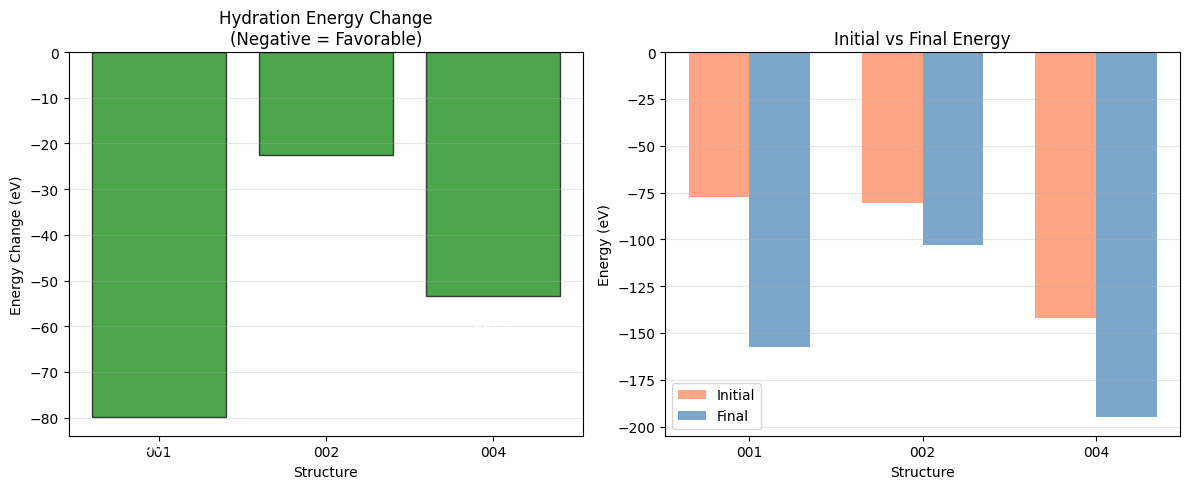

Energy plot saved


In [14]:
# 에너지 변화 시각화 (초기 vs 최종 비교)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. 에너지 변화 막대 그래프
ax1 = axes[0]
names = [md['name'].replace('structure_', '').replace('_opt', '') for md in md_results]
energy_changes = [md['energy_change'] for md in md_results]

colors = ['green' if e < 0 else 'red' for e in energy_changes]
bars = ax1.bar(names, energy_changes, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Structure')
ax1.set_ylabel('Energy Change (eV)')
ax1.set_title('Hydration Energy Change\n(Negative = Favorable)')
ax1.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar, val in zip(bars, energy_changes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 5, 
             f'{val:.1f}', ha='center', va='top', fontweight='bold', color='white')

# 2. 초기/최종 에너지 비교
ax2 = axes[1]
x = np.arange(len(md_results))
width = 0.35

initial_e = [md['initial_energy'] for md in md_results]
final_e = [md['final_energy'] for md in md_results]

bars1 = ax2.bar(x - width/2, initial_e, width, label='Initial', color='coral', alpha=0.7)
bars2 = ax2.bar(x + width/2, final_e, width, label='Final', color='steelblue', alpha=0.7)

ax2.set_xlabel('Structure')
ax2.set_ylabel('Energy (eV)')
ax2.set_title('Initial vs Final Energy')
ax2.set_xticks(x)
ax2.set_xticklabels(names)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'figures' / 'mattergen_hydration_energy.png', dpi=150)
plt.show()

print("Energy plot saved")

## 7. 결과 요약 및 저장

In [15]:
# 결과 테이블
summary_data = []

for md in md_results:
    row = {
        'Name': md['name'],
        'Formula': md['original_formula'],
        'Initial E (eV)': f"{md['initial_energy']:.2f}",
        'Final E (eV)': f"{md['final_energy']:.2f}",
        'dE (eV)': f"{md['energy_change']:.2f}"
    }
    
    if 'csh_indicators' in md:
        ind = md['csh_indicators']
        if 'ca_displacement' in ind:
            row['Ca Displacement (A)'] = f"{ind['ca_displacement']:.3f}"
        if 'si_coordination_mean' in ind:
            row['Si Coord'] = f"{ind['si_coordination_mean']:.2f}"
    
    summary_data.append(row)

df_summary = pd.DataFrame(summary_data)

print("\n" + "=" * 70)
print("MatterGen Hydration Simulation Results")
print("=" * 70)
print(df_summary.to_string(index=False))


MatterGen Hydration Simulation Results
             Name   Formula Initial E (eV) Final E (eV) dE (eV) Ca Displacement (A) Si Coord
structure_001_opt  AlCaOSi3         -77.47      -157.45  -79.98               8.659     0.00
structure_002_opt CaFe2O4Si         -80.42      -102.86  -22.44               7.742     0.00
structure_004_opt AlCa2O4Si        -141.79      -195.12  -53.33               2.821     2.00


In [16]:
# JSON 저장
def convert_numpy(obj):
    if isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    if isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_numpy(i) for i in obj]
    return obj

# 저장용 데이터 정리
hydration_results = {
    'simulation_params': {
        'n_water': N_WATER if 'N_WATER' in dir() else 15,
        'md_time_ps': 2.0,  # 시뮬레이션 시간 (ps)
        'temperature_K': 300
    },
    'results': [
        {
            'name': md['name'],
            'original_formula': md['original_formula'],
            'hydrated_formula': md['hydrated_formula'],
            'initial_energy': md['initial_energy'],
            'final_energy': md['final_energy'],
            'energy_change': md['energy_change'],
            'traj_path': md['traj_path'],
            'csh_indicators': md.get('csh_indicators', {})
        }
        for md in md_results
    ]
}

hydration_results = convert_numpy(hydration_results)

results_path = RESULTS_DIR / 'mattergen_hydration.json'
with open(results_path, 'w') as f:
    json.dump(hydration_results, f, indent=2)

print(f"Results saved: {results_path}")

Results saved: c:\cement_final\data\results\mattergen_hydration.json


---

## 결론

### MatterGen 구조 수화 시뮬레이션 결과

| 지표 | 의미 | 결과 |
|------|------|------|
| 에너지 변화 (dE) | 음수 = 수화 반응 유리 | - |
| Ca 이동 거리 | 클수록 용출 활발 | - |
| Si 배위수 | 4 = 정상, 변화 = 재구성 | - |

### 다음 단계

이 결과는 **11_Final_Comparison.ipynb**에서 기존 Top 5 산업폐기물 후보와 비교됩니다.